In [1]:
import os, json
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F

In [2]:
DATA_PATH = "../data/fouriers/"

files = os.listdir(DATA_PATH)

fouriers = defaultdict(lambda: [])
for file in files:
    fourier = json.load(open(DATA_PATH + file, "r"))
    fouriers[fourier["label"]].append(fourier["powers"])
fouriers = { label: np.array(powers) for label, powers in fouriers.items() }

In [9]:
"""
Hulk whistle detection.
"""

SAMPLE_RATE = 48000
NYQUIST = SAMPLE_RATE / 2 + 1

n_freqs = fouriers[True][0].shape[0]

MIN_FREQ, MAX_FREQ = 2000, 4000
# corresponding spectrum indices
min_i, max_i = int(MIN_FREQ * n_freqs / NYQUIST), int(MAX_FREQ * n_freqs / NYQUIST)

# TODO: would without euclidean scaling work better?
def detect(energy: np.ndarray) -> bool:
    """
    Detects whistle.

    It searches for a potential whistle brandwith from `start_i` to `end_i`,
    and if it exists and the energy is high enough, as whistle is detected.
    """

    mean = np.mean(energy)
    threshold = mean * 2.

    start_i, end_i = None, None
    for i in range(min_i, max_i):
        if energy[i] > threshold:
            start_i = i
            break
    # the vibes are off (not enough energy)
    if start_i is None:
        return False
    
    for i in range(max_i, start_i, -1):
        if energy[i] > threshold:
            end_i = i
            break    
    # the vibes are off (not enough energy)
    if end_i is None:
        return False
    
    threshold = mean * 8.
    return np.mean(energy[start_i:end_i]) > threshold

iters = 1000
true_acc, false_acc = 0.0, 0.0
for i in range(iters):
    true_acc += float(detect(fouriers[True][i]))
    false_acc += 1.0 - float(detect(fouriers[False][i]))
true_acc /= iters
false_acc /= iters

In [10]:
true_acc, false_acc

(0.901, 0.951)

In [59]:
"""
Find example of false positive.
"""

false_positives = []
iters = 1000
for i in range(iters):
    if detect(fouriers[False][i]):
        false_positives.append(i)
false_positives[:10]

[1, 8, 30, 52, 65, 82, 89, 94, 118, 126]

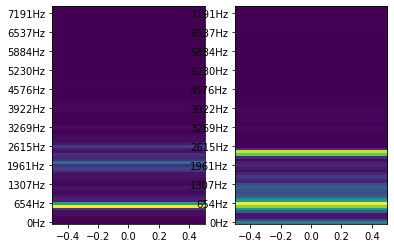

In [60]:
LAG = 256
SAMPLE_RATE = 48000
NYQUIST = SAMPLE_RATE / 2 + 1

N_FREQS = 80

#avg_whistle = (np.roll(fouriers[True][420], 10) + np.median(fouriers[False], axis=0)) * 0.5
# avg_whistle = np.mean(fouriers[True], axis=0)
# avg_non_whistle = np.mean(fouriers[False], axis=0)
avg_whistle = fouriers[False][false_positives[0]]
avg_non_whistle = fouriers[False][false_positives[1]]

fig, (ax0, ax1) = plt.subplots(1, 2)
img = np.array([avg_whistle[:N_FREQS]]).T
ax0.imshow(img, cmap="viridis", interpolation="none", aspect="auto", origin="lower")

yticks = np.arange(0, img.shape[0], 7)
yticklabels = [f"{i / avg_whistle.shape[0] * NYQUIST:.0f}Hz" for i in yticks]
ax0.set_yticks(yticks, yticklabels);

img = np.array([avg_non_whistle[:N_FREQS]]).T
ax1.imshow(img, cmap="viridis", interpolation="none", aspect="auto", origin="lower")
ax1.set_yticks(yticks, yticklabels);

In [5]:
class TwoLayerIntegrated(nn.Module):
    def __init__(self, input_dim):
        super(TwoLayerIntegrated, self).__init__()
        
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.sigmoid(self.layer2(x))
        
        return x

model = TwoLayerIntegrated(avg_whistle.shape[0])
model.load_state_dict(torch.load("../models/whistle_detection.pth"))
model.eval()

TwoLayerIntegrated(
  (layer1): Linear(in_features=257, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=1, bias=True)
)

In [13]:
#input = (np.mean(fouriers[True], axis=0) + np.mean(fouriers[False], axis=0)) * 0.5
input = (np.roll(fouriers[True][420], 10))*0.2# + np.median(fouriers[False], axis=0)) * 0.5
model(torch.tensor(input.astype("float32")))

tensor([0.3996], grad_fn=<SigmoidBackward0>)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")